In [1]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt

ox.__version__

'2.0.1'

In [2]:
bus_stop_graph = ox.io.load_graphml("data/graph_bus_stop.graphml")
train_graph = ox.io.load_graphml("data/graph_train.graphml")

In [3]:
# Merge the graphs
combined_graph = nx.compose(train_graph, bus_stop_graph)

<Figure size 1000x1000 with 0 Axes>

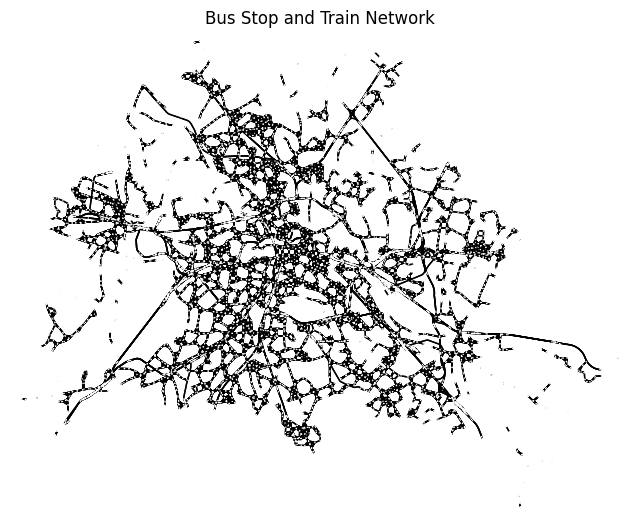

In [4]:
plt.figure(figsize=(10, 10))
# Plot the basic street network
fig, ax = ox.plot_graph(combined_graph, show=False, close=False, bgcolor='white', node_size=1, edge_color='black')

plt.title("Bus Stop and Train Network")
plt.show()

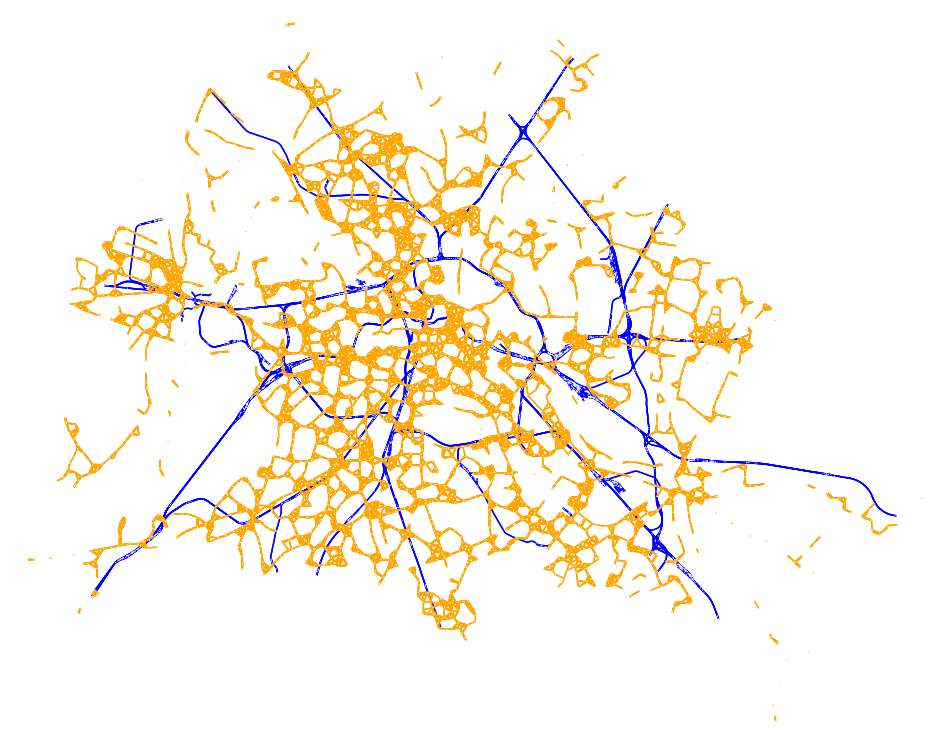

In [5]:
# Plot both networks with different colors
fig, ax = plt.subplots(figsize=(12, 12))
ox.plot_graph(train_graph, ax=ax, node_size=0.5, edge_color='blue', edge_linewidth=1, show=False)
ox.plot_graph(bus_stop_graph, ax=ax, node_size=0.5, edge_color='orange', edge_linewidth=1, show=False)


plt.show()

Nodes with degree <= 2: 133
Nodes with edges ≤ 1 km: 6157
Total filtered nodes: 133


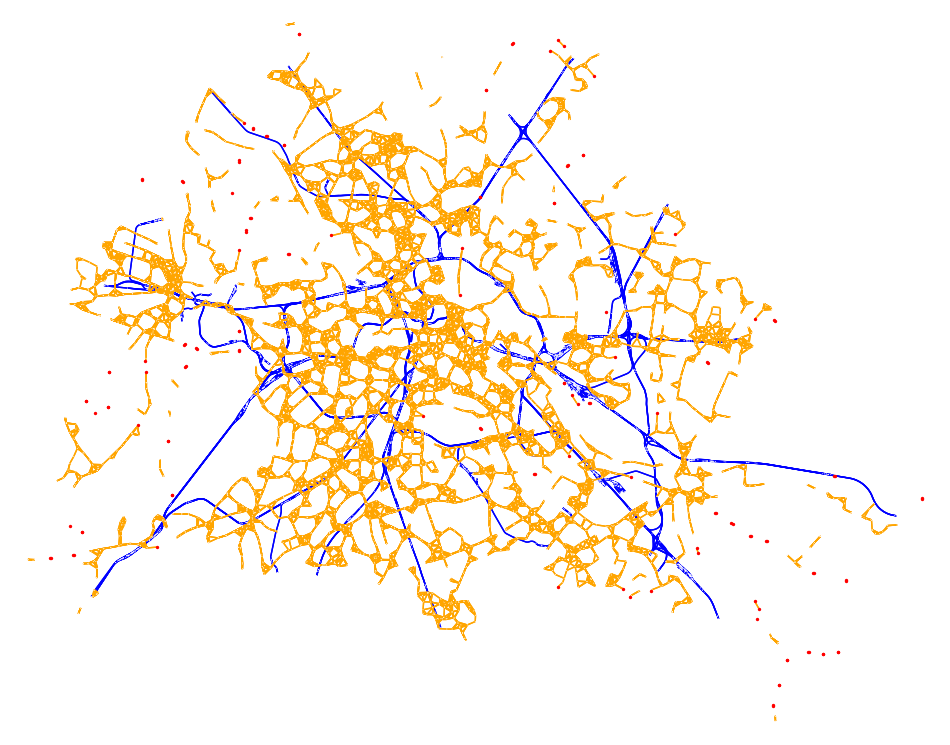

In [6]:
# Find nodes with degree <= 2
low_degree_nodes = [node for node, degree in dict(bus_stop_graph.degree()).items() if degree <= 2]
print(f"Nodes with degree <= 2: {len(low_degree_nodes)}")

# Convert 1 km to meters
max_distance = 1000

# Identify nodes where all connected edges are ≤ 1 km
short_distance_nodes = []

# Find nodes where all edges are ≤ 1 km
for node in bus_stop_graph.nodes:
    # Get all outgoing edges from the node
    edges = bus_stop_graph.edges(node, data=True)
    
    # Check if all edges are within the distance limit
    if all(data.get("length", float('inf')) <= max_distance for _, _, data in edges):
        short_distance_nodes.append(node)
print(f"Nodes with edges ≤ 1 km: {len(short_distance_nodes)}")

# Union of both conditions
filtered_nodes = set(low_degree_nodes) & set(short_distance_nodes)
print(f"Total filtered nodes: {len(filtered_nodes)}")

# Plot networks with different colors and disconnected bus stops 
fig, ax = plt.subplots(figsize=(12, 12))
ox.plot_graph(train_graph, ax=ax, node_size=0.5, edge_color='blue', edge_linewidth=1, show=False)
ox.plot_graph(bus_stop_graph, ax=ax, node_size=0.5, edge_color='orange', edge_linewidth=1, show=False)

# Plot filtered nodes in red
# Prepare the node position dictionary for plotting
pos = {node: (data['x'], data['y']) for node, data in bus_stop_graph.nodes(data=True)}
nx.draw_networkx_nodes(bus_stop_graph, pos=pos, 
                       nodelist=filtered_nodes, node_color="red", node_size=2, ax=ax)


plt.show()

### [Incomplete] Connect Disconnected Bus Stops (Red Nodes) to the Connected Bus Stops

In [7]:
# Load the drive network for Berlin
drive_graph = ox.graph_from_place("Berlin, Germany", network_type="drive")

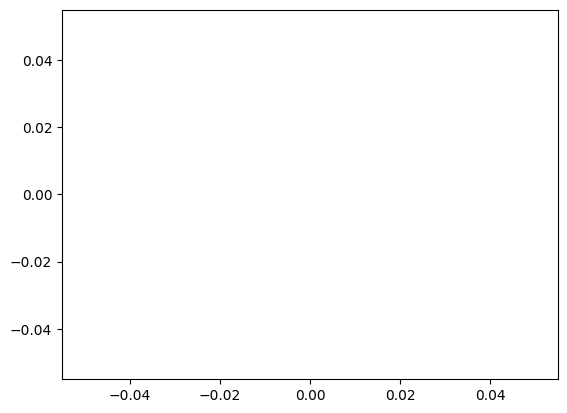

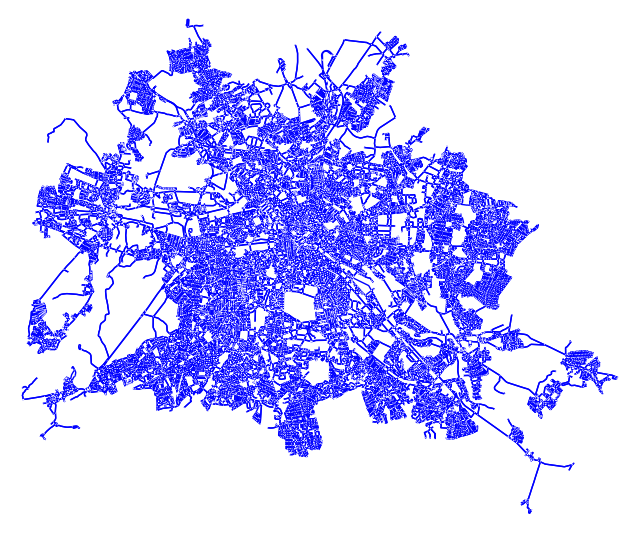

In [8]:
plt.plot(figsize=(12, 12))
ox.plot_graph(drive_graph, node_size=0.5, edge_color='blue', bgcolor='white', edge_linewidth=1, show=False)
plt.show()

In [66]:
# Convert node positions for plotting later
bus_pos = {node: (data['x'], data['y']) for node, data in bus_stop_graph.nodes(data=True)}
pos_drive = {node: (data['x'], data['y']) for node, data in drive_graph.nodes(data=True)}

# Convert filtered nodes to lat/lon for nearest node matching
filtered_node_coords = [(bus_pos[node][1], bus_pos[node][0]) for node in filtered_nodes]

# Find nearest nodes in the drive network of the disconnected nodes
nearest_nodes_drive = [ox.distance.nearest_nodes(drive_graph, x, y) for y, x in filtered_node_coords]

# Exclude the filtered nodes to get nearest node in the connected network
connected_graphs = bus_stop_graph.copy() 
connected_graphs.remove_nodes_from(filtered_nodes)

# Find nearest nodes in the bus stop network for each filtered node
nearest_nodes = [ox.distance.nearest_nodes(drive_graph, x, y) for y, x in filtered_node_coords]
print(f"Nearest nodes in the drive network: {nearest_nodes}")

Nearest nodes in the drive network: [592657225, 1596683752, 1596683752, 288823057, 95947909, 95947909, 10198719170, 10198719170, 150963278, 94483162, 2152120426, 253390675, 28096096, 2152120426, 288823057, 253390675, 1865877932, 262091164, 26984767, 664017794, 272397604, 28320759, 28320759, 28320759, 28320759, 3877089193, 1419207876, 1419207876, 248031676, 248031676, 27126949, 27126950, 27324692, 1242393721, 274115813, 1651781602, 76598376, 289031316, 150963278, 92141841, 274115813, 76598379, 31203412, 92141868, 92141868, 273445087, 92141868, 248502932, 4090512234, 1242393721, 614587422, 29916133, 1838613291, 1407260241, 1808261650, 248502932, 661594841, 306355659, 273120775, 250164853, 273445087, 734249533, 273120775, 734249533, 614587422, 8962646339, 76598376, 8962646339, 96514925, 153728843, 153728843, 1209017495, 411740082, 194016175, 1209011882, 270406510, 1232531376, 4337593777, 593419320, 593419320, 11151140962, 31012067, 30010593, 2580972071, 27559834, 27559834, 31203412, 25956

In [69]:
# Find nearest nodes in the drive network for each connected node
drive_connected_nearest_nodes = [ox.distance.nearest_nodes(drive_graph, data['x'], data['y']) for node, data in connected_graphs.nodes(data=True)]

In [ ]:
# Compute shortest path between all pairs of filtered nodes
shortest_paths = []

for i in range(len(nearest_nodes)):
    for j in range(len(drive_connected_nearest_nodes)):
        source = nearest_nodes[i]
        target = drive_connected_nearest_nodes[j]

        # Check if a path exists between the nodes
        if nx.has_path(drive_graph, source, target):
            try:
                # Calculate the shortest path
                path = nx.shortest_path(drive_graph, source, target, weight="length")
                shortest_paths.append(path)
            except nx.NetworkXNoPath:
                print(f"No path between {source} and {target}")
        else:
            print(f"Skipping disconnected nodes: {source} and {target}")

Skipping disconnected nodes: 592657225 and 6481215449
Skipping disconnected nodes: 592657225 and 6481215449
Skipping disconnected nodes: 592657225 and 444562882
Skipping disconnected nodes: 592657225 and 444562882
Skipping disconnected nodes: 592657225 and 10648153632
Skipping disconnected nodes: 592657225 and 10648153632
Skipping disconnected nodes: 592657225 and 11002889416
Skipping disconnected nodes: 592657225 and 11002889416
Skipping disconnected nodes: 1596683752 and 6481215449
Skipping disconnected nodes: 1596683752 and 6481215449
Skipping disconnected nodes: 1596683752 and 444562882
Skipping disconnected nodes: 1596683752 and 444562882
Skipping disconnected nodes: 1596683752 and 10648153632
Skipping disconnected nodes: 1596683752 and 10648153632
Skipping disconnected nodes: 1596683752 and 11002889416
Skipping disconnected nodes: 1596683752 and 11002889416
Skipping disconnected nodes: 1596683752 and 6481215449
Skipping disconnected nodes: 1596683752 and 6481215449
Skipping disco

In [56]:
# Create a new empty MultiDiGraph
new_graph = nx.MultiDiGraph()

# Add the filtered nodes from the drive graph
for node in nearest_nodes_drive:
    new_graph.add_node(node, x=pos_drive[node][0], y=pos_drive[node][1])

print(f"Nodes added to the new graph: {len(new_graph.nodes)}")

# Add edges using the shortest paths computed earlier
for path in shortest_paths:
    # Add each segment of the path as an edge with its length as a weight
    for i in range(len(path) - 1):
        u, v = path[i], path[i + 1]
        # Calculate edge length for the segment
        edge_length = drive_graph[u][v][0].get('length', 0)
        new_graph.add_edge(u, v, length=edge_length)

print(f"Edges added to the new graph: {len(new_graph.edges)}")

Nodes added to the new graph: 87
Edges added to the new graph: 1152189


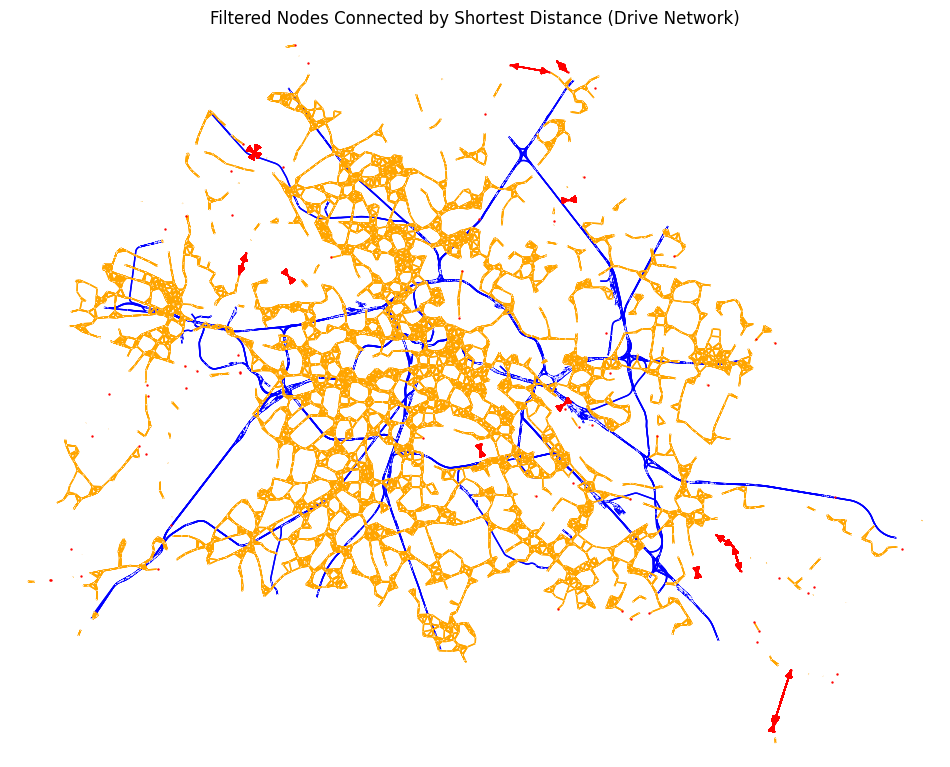

In [58]:
fig, ax = plt.subplots(figsize=(12, 12))
ox.plot_graph(train_graph, ax=ax, node_size=0.5, edge_color='blue', edge_linewidth=1, show=False)
ox.plot_graph(bus_stop_graph, ax=ax, node_size=0.5, edge_color='orange', edge_linewidth=1, show=False)
# Plot filtered nodes in red
# Prepare the node position dictionary for plotting
# pos_new_graph = {node: (data['x'], data['y']) for node, data in new_graph.nodes(data=True)}
pos_new_graph = {}
nodes_to_remove = []
for node, data in new_graph.nodes(data=True):
    if 'x' not in data.keys() or 'y' not in data.keys():
        nodes_to_remove.append(node)
        continue
    
    pos_new_graph[node] = (data['x'], data['y'])

# Remove the identified nodes
new_graph.remove_nodes_from(nodes_to_remove)

nx.draw(new_graph, pos=pos_new_graph, with_labels=False, node_size=0.5, node_color="red", edge_color="red", width=1)

plt.title("Filtered Nodes Connected by Shortest Distance (Drive Network)")
plt.show()